# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random
from glob import glob
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
%matplotlib inline
# create a image generator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go
from tensorflow.keras import regularizers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
  brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
brain_df.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [5]:
data_map = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [7]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_5.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_5_mask.tif


In [8]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
'''pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)'''
brain_df



,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif,/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif,0


# Phân loại

In [9]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [10]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [11]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [12]:
batch_size = 16
epochs = 100
image_size = 256

In [13]:
# split the data into train and test data
train, test = train_test_split(brain_df_train, test_size = 0.2)
# create a image generator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
train_datagen  = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.3,
    rotation_range=20,            # Rotate images by 20 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,       # Randomly shift images vertically by 10% of the height
    zoom_range=0.2,               # Apply random zooming in the range of 0.8 to 1.2
    horizontal_flip=True         # Flip images horizontally
)
     

In [14]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2201 validated image filenames belonging to 2 classes.
Found 942 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


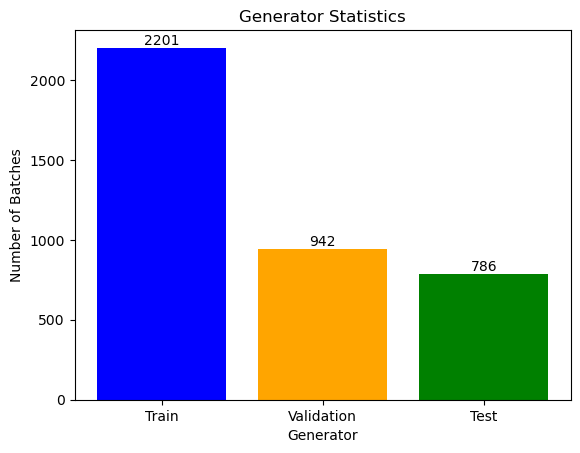

In [15]:
# Calculate the number of batches in each generator
train_steps = train_generator.n
valid_steps = valid_generator.n
test_steps = test_generator.n

# Create a list of labels for the x-axis
labels = ['Train', 'Validation', 'Test']

# Create a list of values for the y-axis
values = [train_steps, valid_steps, test_steps]

# Define the colors for each bar
colors = ['blue', 'orange', 'green']

# Plot the bar chart
plt.bar(labels, values, color=colors)
plt.xlabel('Generator')
plt.ylabel('Number of Batches')
plt.title('Generator Statistics')

# Add the numbers on top of the bars
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()


#  Phân vùng
(seg)

In [16]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


In [17]:
EPOCHS = 100
BATCH_SIZE = 16
learning_rate = 1e-4
im_height=256
im_width=256

In [18]:
train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [19]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
train_count = 2201
val_count = 942
test_count = 786

# Chia tập train ban đầu
df_train_temp, df_test = train_test_split(df, test_size=test_count, random_state=42)

# Chia tập train thành tập train và tập val
df_train, df_val = train_test_split(df_train_temp, test_size=val_count, random_state=42)

print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2201, 2)
(942, 2)
(786, 2)


In [20]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [21]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

# Hàm hỗ trợ
(TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR)

In [22]:
# Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1
smooth=100


def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    binary_crossentropy_loss = K.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return binary_crossentropy_loss + dice_loss

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# Unet-VGG

In [23]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

80134624/80134624 [==============================] - 0s 0us/step


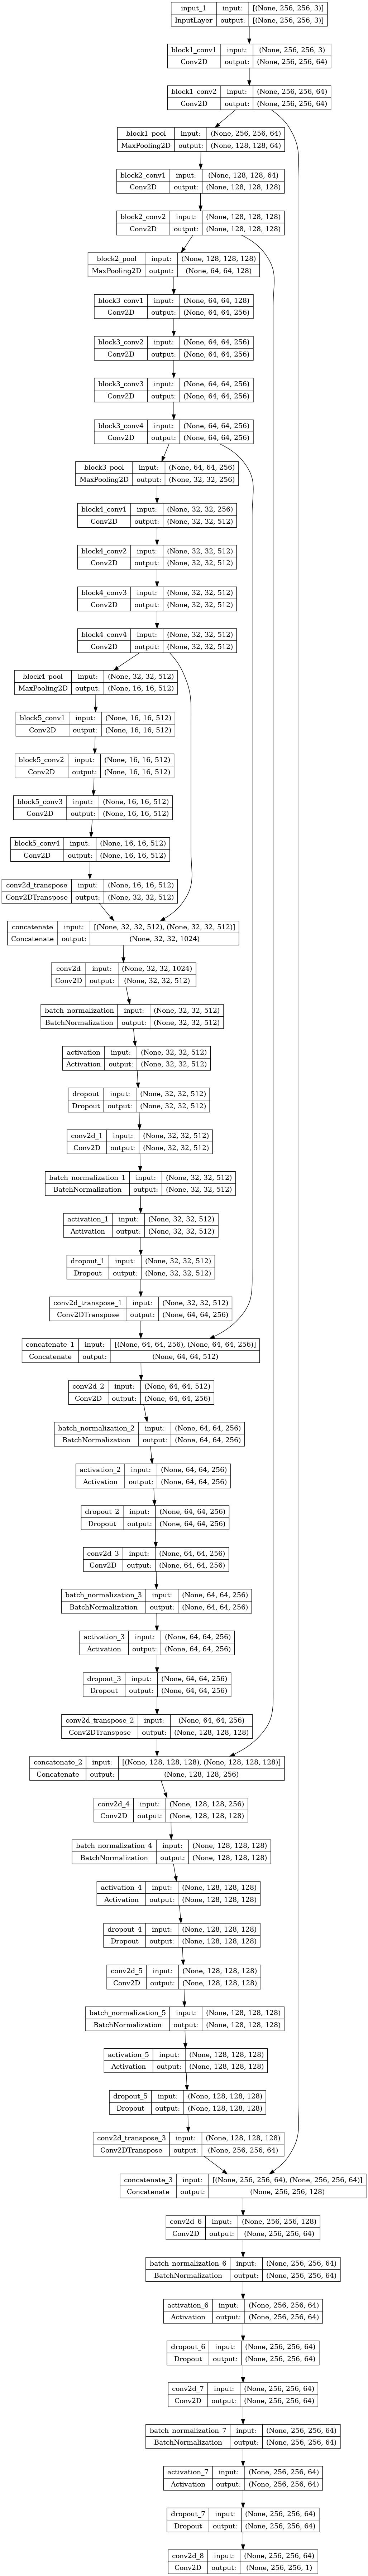

In [24]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)  # Thêm lớp Dropout với tỷ lệ dropout là 0.5

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)  # Thêm lớp Dropout với tỷ lệ dropout là 0.5

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_size=(256, 256, 3)):
    """ Input """
    inputs = Input(input_size)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    display(tf.keras.utils.plot_model(model, to_file='model_vgg19_unet.png', show_shapes=True))
    return model

model_vgg19_unet = build_vgg19_unet()

In [25]:
model_vgg19_unet.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [26]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.001)
model_vgg19_unet.compile(optimizer = adam, 
                  loss = bce_dice_loss, 
                  metrics = [iou, dice_coef, 'accuracy']
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="seg_vgg19_unet.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
start_time = time.time()
history_vgg19_unet = model_vgg19_unet.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks = [checkpointer, earlystopping, reduce_lr],
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE
                 )
end_time = time.time()
vgg19_unet_time = end_time-start_time

Found 2201 validated image filenames.
Found 2201 validated image filenames.
Epoch 1/100


2023-06-25 11:17:35.806392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inVGG19_U-Net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


138/137 [==============================] - ETA: 0s - loss: 0.9460 - iou: 0.1077 - dice_coef: 0.1835 - accuracy: 0.9646Found 942 validated image filenames.
Found 942 validated image filenames.

Epoch 1: val_loss improved from inf to 1.02086, saving model to seg_vgg19_unet.hdf5
137/137 [==============================] - 133s 748ms/step - loss: 0.9460 - iou: 0.1077 - dice_coef: 0.1835 - accuracy: 0.9646 - val_loss: 1.0209 - val_iou: 0.0357 - val_dice_coef: 0.0550 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 2/100
138/137 [==============================] - ETA: 0s - loss: 0.6405 - iou: 0.2676 - dice_coef: 0.4053 - accuracy: 0.9892
Epoch 2: val_loss improved from 1.02086 to 1.01196, saving model to seg_vgg19_unet.hdf5
137/137 [==============================] - 81s 589ms/step - loss: 0.6405 - iou: 0.2676 - dice_coef: 0.4053 - accuracy: 0.9892 - val_loss: 1.0120 - val_iou: 0.0216 - val_dice_coef: 0.0392 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 3/100
138/137 [==============================] - ET

In [27]:
history_vgg19_unet.history.keys()

dict_keys(['loss', 'iou', 'dice_coef', 'accuracy', 'val_loss', 'val_iou', 'val_dice_coef', 'val_accuracy', 'lr'])

In [28]:
vgg19_unet_time

8250.45097064972

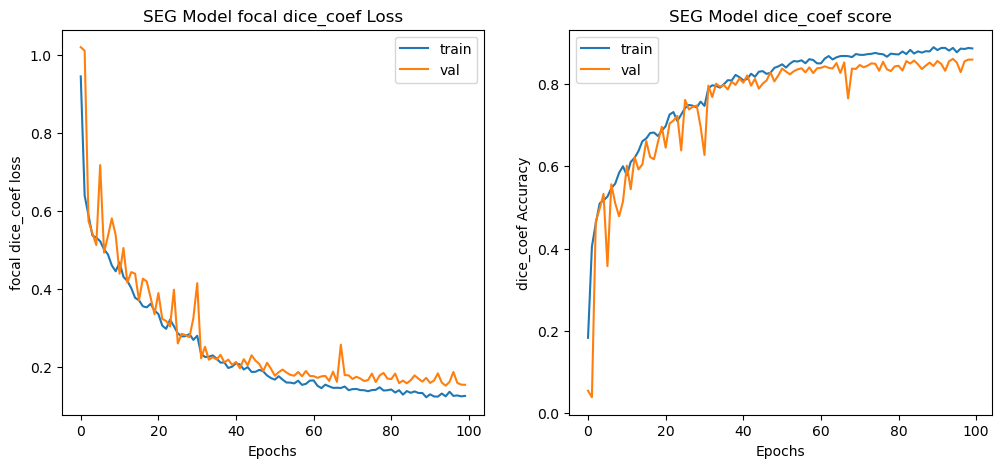

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vgg19_unet.history['loss']);
plt.plot(history_vgg19_unet.history['val_loss']);
plt.title("SEG Model focal dice_coef Loss");
plt.ylabel("focal dice_coef loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_vgg19_unet.history['dice_coef']);
plt.plot(history_vgg19_unet.history['val_dice_coef']);
plt.title("SEG Model dice_coef score");
plt.ylabel("dice_coef Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [30]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results_VggUnet = model_vgg19_unet.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)

print("Test lost {:.2f}%".format(results_VggUnet[0]*100))
print("Test iou {:.2f}%".format(results_VggUnet[1]*100))
print("Test Dice Coefficent: {:.2f}%".format(results_VggUnet[2]*100))

Found 786 validated image filenames.
Found 786 validated image filenames.
49/49 [==============================] - 8s 168ms/step - loss: 0.1527 - iou: 0.7657 - dice_coef: 0.8640 - accuracy: 0.9973
Test lost 15.27%
Test iou 76.57%
Test Dice Coefficent: 86.40%


1/1 [==============================] - 1s 1s/step


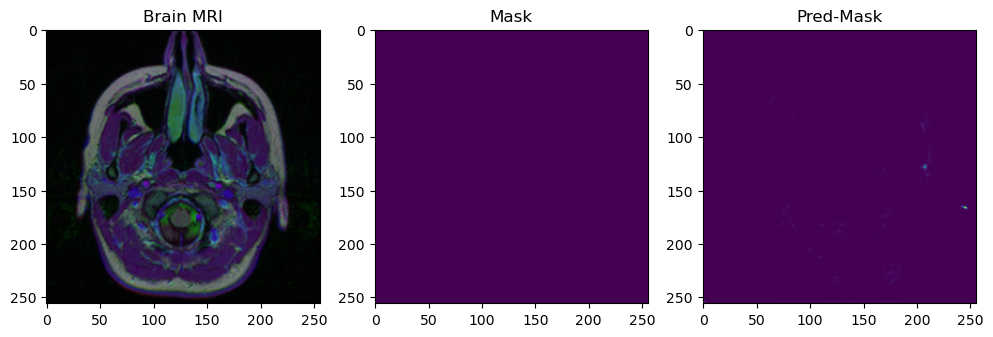

1/1 [==============================] - 0s 20ms/step


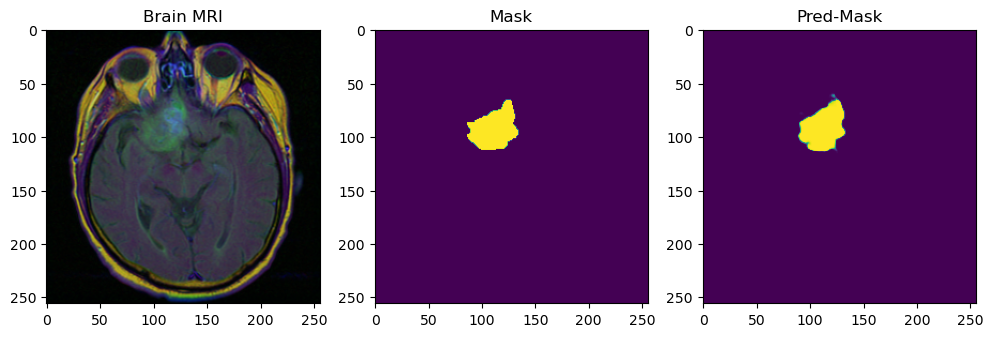

In [31]:
try:
    image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif')
    image=cv2.resize(image,dsize=(256,256))
    image=image /255.0
    image_ex=np.expand_dims(image,axis=0)
    image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif')
    image_mask=cv2.resize(image_mask,dsize=(256,256))
    image_mask=image_mask /255.0
    image_mask_ex=np.expand_dims(image_mask,axis=0)

    # Make prediction
    prediction = model_vgg19_unet.predict(image_ex)
    # Chuyển đổi đầu ra dự đoán và mặt nạ thực thành dạng nhị phân
    threshold = 0.5
    predicted_mask = np.round(prediction)
    true_mask = np.round(image_mask_ex)  # Thay true_mask bằng mặt nạ thực của bạn

    # Tính toán phần trăm chính xác
    accuracy = np.mean(predicted_mask == true_mask) * 100
    #print("Phần trăm chính xác: {:.2f}%".format(accuracy))
    # In kết quả

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Brain MRI");
    plt.subplot(1,3,2)
    plt.imshow(image_mask)
    plt.title("Mask");
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(prediction))
    plt.title("Pred-Mask");
    plt.show()
    print("===========================================================================================================")

    image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')
    image=cv2.resize(image,dsize=(256,256))
    image=image /255.0
    image_ex=np.expand_dims(image,axis=0)
    image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif')
    image_mask=cv2.resize(image_mask,dsize=(256,256))
    image_mask=image_mask /255.0
    image_mask_ex=np.expand_dims(image_mask,axis=0)

    # Make prediction
    prediction = model_vgg19_unet.predict(image_ex)
   # Chuyển đổi đầu ra dự đoán và mặt nạ thực thành dạng nhị phân
    threshold = 0.5
    predicted_mask = np.round(prediction)
    true_mask = np.round(image_mask_ex)  # Thay true_mask bằng mặt nạ thực của bạn

    # Tính toán phần trăm chính xác
    accuracy = np.mean(predicted_mask == true_mask) * 100
    # In kết quả

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Brain MRI");
    plt.subplot(1,3,2)
    plt.imshow(image_mask)
    plt.title("Mask");
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(prediction))
    plt.title("Pred-Mask");
    plt.show()
except ValueError:
    print("Invalid input. Please enter integers only.")
except ZeroDivisionError:
    print("Error: Division by zero is not allowed.")